In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [11]:
import pandas as pd
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog

# Read images

In [12]:
train_imgs = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [13]:
train_imgs.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see that the training labels are in the first column, and all other columns contain the pixel value of a particular 28x28 image

In [14]:
train_data, train_label = train_imgs.drop(['label'], axis=1), train_imgs['label']


Visualise the first 10 images in the train dataset

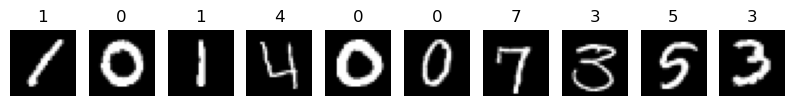

In [15]:
fig, ax = plt.subplots(ncols=10, figsize=(10, 50))
for i in range(10):
        ax[i].imshow(train_data.iloc[i].to_numpy().reshape(28, 28), cmap='gray')
        ax[i].set_title(train_label[i])
        ax[i].axis('off')

# Preprocessing
- Feature extraction using Histogram of Oriented Gradients (HoG). HoG is a popular traditional feature descriptor. In short, HoG extracts information about both the gradient and magnitude of edges in fixed-sized windows in an image. 

Further reading on HoG
1. [skimage docs](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html)
2. [Feature Engineering for Images: A Valuable Introduction to the HOG Feature Descriptor](https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/)

In [24]:
def preprocess_df(df):
    res = []
    for i in range(df.shape[0]):
        img = df.iloc[i].to_numpy().reshape(28, 28).astype(np.uint8)
        hog_features = hog(img, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(1, 1))
        res.append(hog_features.flatten())
    return np.array(res)

In [25]:
preprocessed_train_data = preprocess_df(train_data)

In [26]:
preprocessed_train_data.shape

(42000, 441)

The input image has 784 features corresponding to the $28\times28$ pixel values. HoG divides each image into cells of $4\times4$ pixels, which gives $7\times7=49$ total cells. For each cell, the gradient in the horizontal and vertical direction is calculated, followed by the gradient magnitude and direction for all 16 pixels in the cell. Then, a gradient histogram with 9 bins is computed for each cell. Next, normalisation is applied to each cell in this experiment. The final HoG feature vector is created by stacking histograms of each block into a vector of length $49\times9=441$.

In [27]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)
ohe_train_labels = enc.fit_transform(train_label.to_numpy().reshape(-1, 1))


In [28]:
ohe_train_labels.shape

(42000, 10)

Next, we split the training images using an 80:20 split

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(preprocessed_train_data, ohe_train_labels, test_size=0.2, random_state=28)

In [30]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33600, 441) (8400, 441) (33600, 10) (8400, 10)


# Train model

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, input_shape=(441,), activation='sigmoid'),
    tf.keras.layers.Dense(10)
])

In [32]:
# apply early stopping to training
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.compile(optimizer='adam',
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [33]:
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/150
840/840 [==============================] - 3s 3ms/step - loss: 0.5912 - accuracy: 0.8982 - val_loss: 0.1930 - val_accuracy: 0.9558
Epoch 2/150
840/840 [==============================] - 2s 2ms/step - loss: 0.1457 - accuracy: 0.9627 - val_loss: 0.1231 - val_accuracy: 0.9658
Epoch 3/150
840/840 [==============================] - 2s 2ms/step - loss: 0.1025 - accuracy: 0.9721 - val_loss: 0.1028 - val_accuracy: 0.9685
Epoch 4/150
840/840 [==============================] - 2s 2ms/step - loss: 0.0835 - accuracy: 0.9753 - val_loss: 0.0955 - val_accuracy: 0.9701
Epoch 5/150
840/840 [==============================] - 2s 2ms/step - loss: 0.0711 - accuracy: 0.9804 - val_loss: 0.0926 - val_accuracy: 0.9702
Epoch 6/150
840/840 [==============================] - 2s 2ms/step - loss: 0.0627 - accuracy: 0.9824 - val_loss: 0.0901 - val_accuracy: 0.9698
Epoch 7/150
840/840 [==============================] - 2s 2ms/step - loss: 0.0552 - accuracy: 0.9847 - val_loss: 0.0875 - val_accuracy: 0.9695

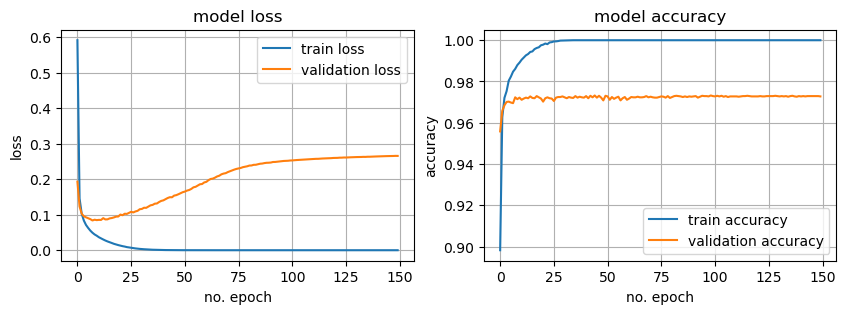

In [34]:
# plot accuracy and loss curves
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))

ax[0].plot(history.history['loss'], label='train loss')
ax[0].plot(history.history['val_loss'], label='validation loss')
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('no. epoch')
ax[0].legend()
ax[0].grid()

ax[1].plot(history.history['accuracy'], label='train accuracy')
ax[1].plot(history.history['val_accuracy'], label='validation accuracy')
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('no. epoch')
ax[1].legend()
ax[1].grid()
plt.show()

In [35]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.2%}, Test Loss={test_loss:.4f}')

263/263 - 0s - loss: 0.2999 - accuracy: 0.9726 - 482ms/epoch - 2ms/step
Test accuracy: 97.26%, Test Loss=0.2999


Based on the loss curve, it can be seen that the model begins to overfit after around 15 epochs. Hence, a better metric to monitor for early stopping would be validation loss.

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, input_shape=(441,), activation='sigmoid'),
    tf.keras.layers.Dense(10)
])

# apply early stopping to training
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer='adam',
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/150
840/840 [==============================] - 3s 3ms/step - loss: 0.5793 - accuracy: 0.9020 - val_loss: 0.1934 - val_accuracy: 0.9543
Epoch 2/150
840/840 [==============================] - 2s 2ms/step - loss: 0.1455 - accuracy: 0.9639 - val_loss: 0.1261 - val_accuracy: 0.9640
Epoch 3/150
840/840 [==============================] - 2s 2ms/step - loss: 0.1035 - accuracy: 0.9713 - val_loss: 0.1084 - val_accuracy: 0.9664
Epoch 4/150
840/840 [==============================] - 2s 3ms/step - loss: 0.0843 - accuracy: 0.9761 - val_loss: 0.0981 - val_accuracy: 0.9682
Epoch 5/150
840/840 [==============================] - 2s 2ms/step - loss: 0.0722 - accuracy: 0.9787 - val_loss: 0.0927 - val_accuracy: 0.9696
Epoch 6/150
840/840 [==============================] - 2s 2ms/step - loss: 0.0625 - accuracy: 0.9824 - val_loss: 0.0910 - val_accuracy: 0.9701
Epoch 7/150
840/840 [==============================] - 2s 2ms/step - loss: 0.0554 - accuracy: 0.9839 - val_loss: 0.0892 - val_accuracy: 0.9698

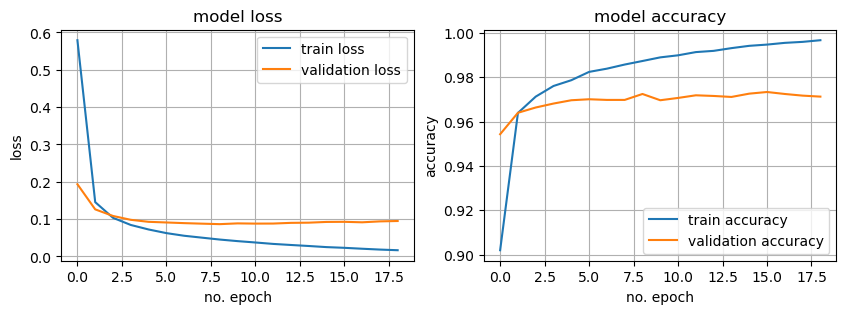

In [37]:
# plot accuracy and loss curves
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))

ax[0].plot(history.history['loss'], label='train loss')
ax[0].plot(history.history['val_loss'], label='validation loss')
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('no. epoch')
ax[0].legend()
ax[0].grid()

ax[1].plot(history.history['accuracy'], label='train accuracy')
ax[1].plot(history.history['val_accuracy'], label='validation accuracy')
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('no. epoch')
ax[1].legend()
ax[1].grid()
plt.show()

In [38]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.2%}, Test Loss={test_loss:.4f}')

263/263 - 0s - loss: 0.0913 - accuracy: 0.9699 - 476ms/epoch - 2ms/step
Test accuracy: 96.99%, Test Loss=0.0913


# Make predictions on test images

In [39]:
# read testimages
test_imgs = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
print(test_imgs.shape)

(28000, 784)


In [40]:
# preprocess test images
preprocessed_test_data = preprocess_df(test_imgs)

In [41]:
# make predictions using model
scores = model.predict(preprocessed_test_data)
preds = np.argmax(scores, axis=1) # the class with the highest score is selected as the predicted class

875/875 [==============================] - 1s 1ms/step


In [42]:
# create results dataframe
res_df = pd.DataFrame({'ImageId':list(range(1, 28001)), 'Label':preds})

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [43]:
# write results to a csv file for submission
res_df.to_csv('submission.csv', index=False)